### CLASSIFICATION

In [380]:
# открываем clean_df с part_3
import pandas as pd
clean_df= pd.read_csv('part_3.csv')
clean_df.drop('Unnamed: 0',inplace = True,axis = 1)
print(clean_df.shape)
clean_df['checked_churn'].value_counts()

(531, 33)


0    372
1    159
Name: checked_churn, dtype: int64

In [381]:
# открываем feature_df с part_3
import pandas as pd
feature_df= pd.read_csv('part_2_feature_df.csv')
feature_df.drop('Unnamed: 0',inplace = True,axis = 1)
print(feature_df.shape)
feature_df.head(1)

(531, 3455)


,able,able get,able help,able redeem,able watch,absolutely,absolutely horrendous,absolutely suck,acce,access,...,zip code,𝐋𝐄𝐀𝐃𝐄𝐑,location_proba,rfm,sin_time,cos_time,text_len,topic,fact,polarity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.003766,331,-0.002982,0.999996,51,14,1,-0.15


In [382]:
# checked_churn = list(clean_df['checked_churn'])
# feature_df['checked_churn'] = checked_churn
# feature_df['checked_churn'].value_counts()

In [383]:
# делааем split 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

train_x, valid_x, train_y, valid_y = \
    train_test_split(feature_df, clean_df['checked_churn'], \
    test_size=0.2, random_state=45)

In [384]:
# разбивка у train и valid +- одинаковая
print(train_y.value_counts()/train_y.shape[0])
print(valid_y.value_counts()/valid_y.shape[0])
print(len(train_x))
print(len(valid_x))

0    0.700472
1    0.299528
Name: checked_churn, dtype: float64
0    0.700935
1    0.299065
Name: checked_churn, dtype: float64
424
107


In [385]:
import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score,roc_curve,precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV


In [386]:
# объявим словарь, куда будем собирать roc_auc
r_a = dict()

###   наивный байес

In [387]:
# оставим только TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# благодаря параметру max_features мы оставляем 80% самых выжных фичей
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),max_features = int(0.8 * 4309))
final_tf_idf = tf_idf_vect.fit_transform(clean_df['clean_text'].values)


feature_names = tf_idf_vect.get_feature_names()
nb_tf_idf = pd.DataFrame(final_tf_idf.toarray(), columns = feature_names)
nb_tf_idf.shape

(531, 3447)

In [388]:
train_tfidf_x, valid_tfidf_x, train_tfidf_y, valid_tfidf_y = \
    train_test_split(nb_tf_idf, clean_df['checked_churn'], \
    test_size=0.2, random_state=45)

In [389]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(train_tfidf_x,train_tfidf_y)
y_pred_nb =nb.predict(valid_tfidf_x)
print('для наивного Байеса', roc_auc_score(valid_tfidf_y, y_pred_nb))
r_a['NB'] = roc_auc_score(valid_tfidf_y, y_pred_nb)

для наивного Байеса 0.546875


###  логистическая регрессия 

In [390]:

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_x,train_y)
y_pred_lr =lr.predict(valid_x)

print('для логистической регрессии', roc_auc_score(valid_y, y_pred_lr))
r_a['lr'] = roc_auc_score(valid_y, y_pred_lr)

для логистической регрессии 0.8908333333333334


C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [391]:
# Решётка для перебора параметра 
param_grid = {'C': [0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}
grid_cv_lr = GridSearchCV(lr, param_grid, cv = 5)
grid_cv_lr.fit(train_x, train_y)

print('Лучшее значение параметра регуляризации:', grid_cv_lr.best_params_)

# Сделали прогнозы
y_pred_lr_grid = grid_cv_lr.predict(valid_x)

C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

Лучшее значение параметра регуляризации: {'C': 10}


C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [392]:
print('для логистической регрессии с grid_search', roc_auc_score(valid_y, y_pred_lr_grid))
r_a['gs_lr'] = roc_auc_score(valid_y, y_pred_lr_grid)

для логистической регрессии с grid_search 0.9131250000000001


#### нормирование данных

In [393]:
from sklearn.preprocessing import MinMaxScaler  # класс для скалирования! 

# Он сам будет считать максимумы, минимумы и делить! 

# Объеявили скалировшик 
scaler = MinMaxScaler( )

# Обучили его на тренировочной выборке (он само посчитал все максимумы, минимумы, поделил)
scaler.fit(feature_df) 

# Теперь применяем его к нашим данным 
norm_feature_df = pd.DataFrame(scaler.transform(feature_df),columns =list(feature_df.columns) )
norm_feature_df.shape

(531, 3455)

In [394]:
norm_train_x, norm_valid_x, norm_train_y, norm_valid_y = \
    train_test_split(norm_feature_df, clean_df['checked_churn'], \
    test_size=0.2, random_state=45)

In [395]:
norm_valid_y.shape

(107,)

In [396]:
norm_lr = LogisticRegression()
norm_lr.fit(norm_train_x,norm_train_y)
norm_y_pred_lr =norm_lr.predict(norm_valid_x)

print('для логистической регрессии с нормированеми данными', roc_auc_score(norm_valid_y, norm_y_pred_lr))
r_a['norm_lr'] = roc_auc_score(norm_valid_y, norm_y_pred_lr)

для логистической регрессии с нормированеми данными 0.9085416666666667


In [397]:
# Решётка для перебора параметра 
param_grid = {'C': [0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}
grid_cv_lr = GridSearchCV(norm_lr, param_grid, cv = 5)
grid_cv_lr.fit(norm_train_x, norm_train_y)

print('Лучшее значение параметра регуляризации:', grid_cv_lr.best_params_)

# Сделали прогнозы
norm_y_pred_lr_grid = grid_cv_lr.predict(norm_valid_x)


Лучшее значение параметра регуляризации: {'C': 10}


In [398]:
print('для логистической регрессии с grid_search и нормированием', roc_auc_score(norm_valid_y, norm_y_pred_lr_grid))
r_a['norm__gs_lr'] = roc_auc_score(norm_valid_y, norm_y_pred_lr_grid)

для логистической регрессии с grid_search и нормированием 0.8952083333333333


### Решающее дерево

In [399]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(norm_train_x, norm_train_y)

norm_pred_rf = rnd_clf.predict(norm_valid_x)
print('для решающего дерева', roc_auc_score(norm_valid_y, norm_pred_rf))
r_a['DT'] = roc_auc_score(norm_valid_y, norm_pred_rf)

для решающего дерева 0.9308333333333334


### Lightgbm

#### попытка 1. код по учебным материалам

In [400]:
import lightgbm as gbm

params_gbm = {
    "objective": 'binary',
    "max_depth": 4,
    "min_child_weight" : 2,
    "n_estimators": 100,
    "learning_rate": 0.05,
    'metric':'auc',
    "early_stopping_round":20
    }



In [401]:
x_train,x_test = train_test_split(feature_df)
y_train,y_test = train_test_split(clean_df['checked_churn'])

x_train,x_valid = train_test_split(x_train)
y_train,y_valid = train_test_split(y_train)

In [402]:
model = gbm.train(params_gbm, 
                  train_set = gbm.Dataset(train_x, label=train_y),
                  valid_sets = [gbm.Dataset(x_valid,label=y_valid)])

C:\Users\au00174\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\au00174\Anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 127, number of negative: 297
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 424, number of used features: 22
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.299528 -> initscore=-0.849545
[LightGBM] [Info] Start training from score -0.849545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.578333
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc: 0.578333
[LightGBM] [Warning

In [403]:
y_pred_proba = model.predict(x_test)
y_pred = (y_pred_proba>0.5)*1
roc_auc_score(y_test,y_pred)

0.5

#### попытка 2. исправленный код по учебным материалам

In [404]:
params_gbm = {
    "objective": 'binary',
    "max_depth": 4,
    "min_child_weight" : 2,
    "n_estimators": 100,
    "learning_rate": 0.05,
    'metric':'auc'
    }

d_train = gbm.Dataset(train_x, label=train_y, free_raw_data = False)

model2 = gbm.train(params_gbm, d_train)
y_pred = model2.predict(valid_x)
print(roc_auc_score(valid_y,y_pred))

C:\Users\au00174\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 127, number of negative: 297
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 424, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.299528 -> initscore=-0.849545
[LightGBM] [Info] Start training from score -0.849545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

####  попытка 3.по материалам 

https://github.com/DevmallyaK/Lightgbm-Classifier-in-Python/blob/main/Lightgbm%20Classifier%20in%20Python.ipynb

In [405]:
# попробуем в деле lightgbm
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(train_x, train_y)
lgb_y_pred=clf.predict(valid_x)
print(roc_auc_score(valid_y,lgb_y_pred))
r_a['lgb'] = roc_auc_score(valid_y,lgb_y_pred)
# для проверки переобучения сверимся со значением roc_auc на тренировочных данных
lgb_y_pred_train = clf.predict(train_x)
print(roc_auc_score(train_y,lgb_y_pred_train))

0.9420833333333334
1.0


### выбор лучшей модели

In [406]:
r_a

{'NB': 0.546875,
 'lr': 0.8908333333333334,
 'gs_lr': 0.9131250000000001,
 'norm_lr': 0.9085416666666667,
 'norm__gs_lr': 0.8952083333333333,
 'DT': 0.9308333333333334,
 'lgb': 0.9420833333333334}

In [407]:
roc_auc = pd.DataFrame(r_a,index=[0]).transpose()
roc_auc.rename(columns={0:'roc_auc'})

,roc_auc
NB,0.546875
lr,0.890833
gs_lr,0.913125
norm_lr,0.908542
norm__gs_lr,0.895208
DT,0.930833
lgb,0.942083


#### лучшее значение у lightgbm - 0.88

In [408]:
def roc_auc_pic(y_hat_test, y_test):    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
    roc_auc_test = roc_auc_score(y_test, y_hat_test)

    plt.rcParams['figure.figsize'] = (8, 8)
    plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show() 
    pass

def plot_precision_recall_curve(y_pred_proba, y_test):
    plt.figure(figsize=(10, 10))
    f_scores = np.linspace(0.4, 0.9, num=6)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    precision, recall, _ =  precision_recall_curve(y_test, y_pred_proba)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall', size=15)
    plt.ylabel('Precision', size=15)
    plt.title('Precision-Recall curve', size=18)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()

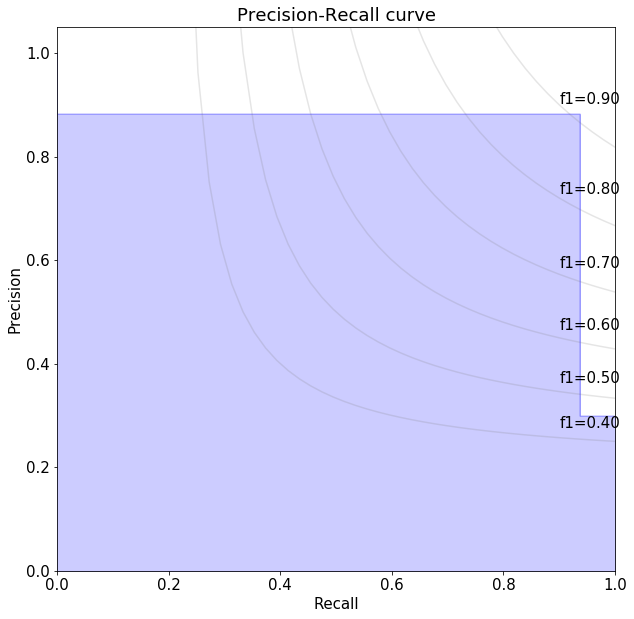

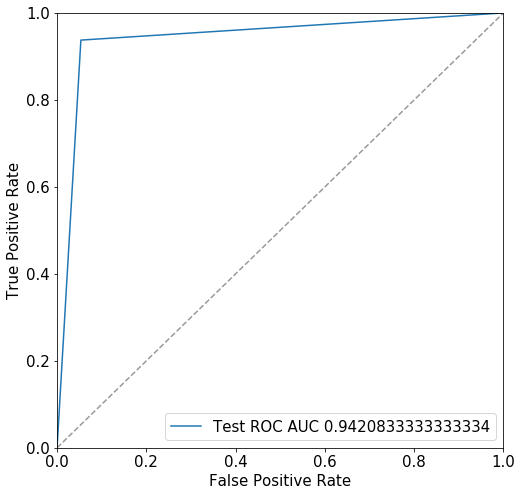

In [409]:
plot_precision_recall_curve(lgb_y_pred,valid_y)
roc_auc_pic(lgb_y_pred,valid_y)

In [410]:
# confusion_matrix - Воспользуемся функцией построения матрицы ошибок из документации sklearn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[71  4]
 [ 2 30]]


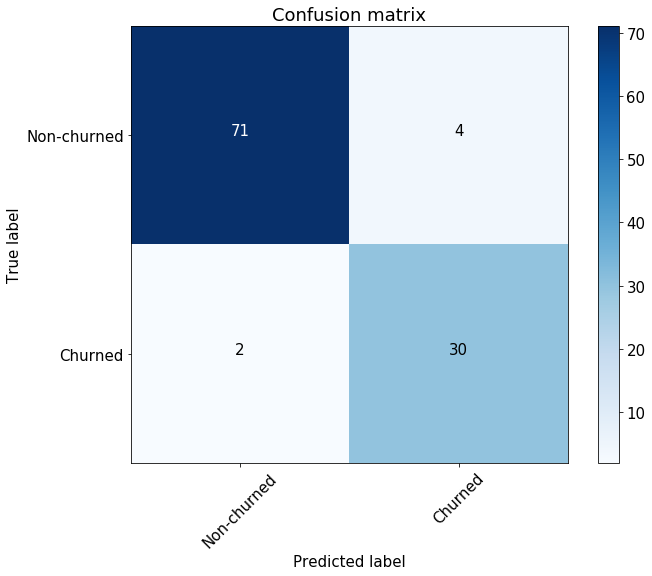

In [411]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(valid_y, lgb_y_pred)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [412]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valid_y, lgb_y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

from sklearn.metrics import classification_report
print(classification_report(valid_y, lgb_y_pred))

Confusion matrix

 [[71  4]
 [ 2 30]]

True Positives(TP) =  71

True Negatives(TN) =  30

False Positives(FP) =  4

False Negatives(FN) =  2
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        75
           1       0.88      0.94      0.91        32

    accuracy                           0.94       107
   macro avg       0.93      0.94      0.93       107
weighted avg       0.95      0.94      0.94       107



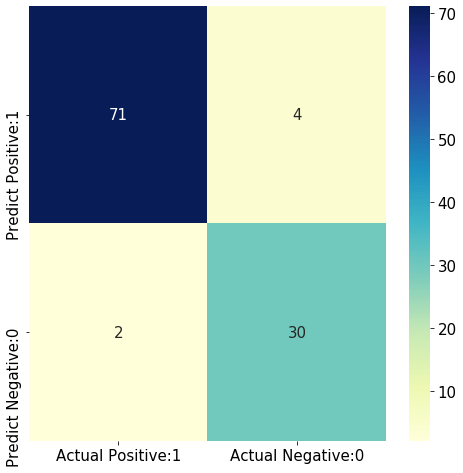

In [413]:
import seaborn as sns
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [414]:
from sklearn.model_selection import cross_validate # подгрузили модель

model = lgb.LGBMClassifier()
scores = cross_validate(model,feature_df,clean_df['checked_churn'],cv = 5,scoring = ('roc_auc'),return_train_score = True)
scores

{'fit_time': array([0.33995366, 0.37907195, 0.36639357, 0.31747079, 0.27295089]),
 'score_time': array([0.07301974, 0.06048131, 0.06447721, 0.06246495, 0.06046653]),
 'test_score': array([0.98416667, 0.99354839, 0.97550676, 0.99788851, 0.95819257]),
 'train_score': array([1., 1., 1., 1., 1.])}

# КОНЕЦ

### вопросы:

    1. нужно ли нормализовать данные перед отправкой на кластеризацию - с ней качество кластеризации падает
    2. нормальная ли логика проверки адекватности кластеризации - проверить по silhouette и сравнить roc_aucом с наивными лейблами 
    3. можно ли сказать,что алгоритм был заинмствован 
    4. rule-based не работает , потому что он накидывался на ручные лейблы
    5. какой алгоритм lightgbm верный?

### как продолжать работу:

    1.upd_EDA project 

       V унифицировать картинки + отсортировать по убыванию
       - ??? проработать emoji
       - поиск твитов по неделям
    
    2. clustering 
        
       V кумулятивный tfidf - поставил критерий max_feature
       V  добавить text_len и topic ,fact,sin_time	cos_time в кластериазцию
       V добавить метрики кластеризации
                попробовать разбиения с разными расстояниями и вывести лучшее по silhette score
                сравнить разбиения с разными расстояниями против размеченных данных вручную
       ?V нормировать значения перед модельками
       V метод главных компонент для визуализации
       
    
    3. rule-based
        
        V добавить свои слова в поиск 10 слов
        V таргетировать churn по rule_based alg 
        V сохранить новый churn в clean_df и в файл
        
     4. classification
        V почитать про наивный байес
        V заменить модель на lightgbm 
         
     5. текст + презентация
         - текст + картинки + презентация (оставить 2-3 дня на это)

In [127]:
# Classification Models and Success metrics
  

  
def model(classifier, train_vector, valid_vector,train_y,valid_y):
    classifier.fit(train_vector, train_y)  
    predict_y = classifier.predict(valid_vector)
    accuracy = accuracy_score(valid_y, predict_y)
    precision = precision_score(valid_y, predict_y,labels=[0,1,2,3,4,5,6],average=None)
    recall = recall_score(valid_y, predict_y,labels=[0,1,2,3,4,5,6],average=None)
    conf_matrix = confusion_matrix(valid_y, predict_y)
    print('\nAccuracy_score: {:.3f}'.format(accuracy ))
    print('precision_score: {:.3f}'.format(precision.mean()))
    print('recall_score: {:.3f}'.format(recall.mean()))
    print('roc_auc_score',roc_auc_score(valid_y, predict_y))
    print('\nconfusion_matrix: \n')
    
    print(confusion_matrix(valid_y, predict_y))
    print(classification_report(valid_y, predict_y))
    
    return roc_auc_pic(predict_y, valid_y),plot_precision_recall_curve(predict_y, valid_y)

# roc_auc_pic

def roc_auc_pic(y_hat_test, y_test):    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
    roc_auc_test = roc_auc_score(y_test, y_hat_test)

    plt.rcParams['figure.figsize'] = (8, 8)
    plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show() 
    pass
# roc_auc_pic(y_pred_lr, valid_y)


# precision_recall

def plot_precision_recall_curve(y_pred_proba, y_test):
    plt.figure(figsize=(10, 10))
    f_scores = np.linspace(0.4, 0.9, num=6)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    precision, recall, _ =  precision_recall_curve(y_test, y_pred_proba)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall', size=15)
    plt.ylabel('Precision', size=15)
    plt.title('Precision-Recall curve', size=18)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()
# plot_precision_recall_curve(y_pred_lr, valid_y)

C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy_score: 0.888
precision_score: 0.254
recall_score: 0.242
roc_auc_score 0.84709911361805

confusion_matrix: 

[[70  3]
 [ 9 25]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        73
           1       0.89      0.74      0.81        34

    accuracy                           0.89       107
   macro avg       0.89      0.85      0.86       107
weighted avg       0.89      0.89      0.88       107



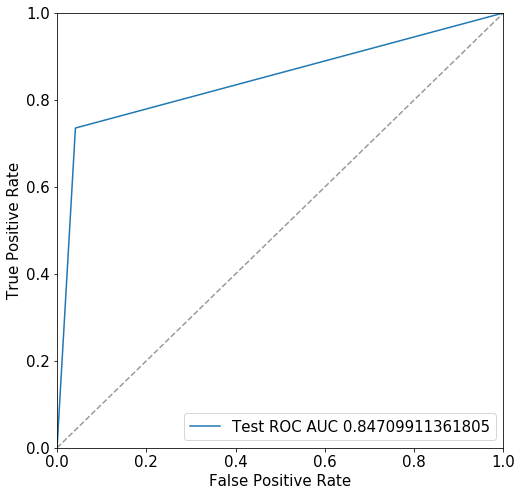

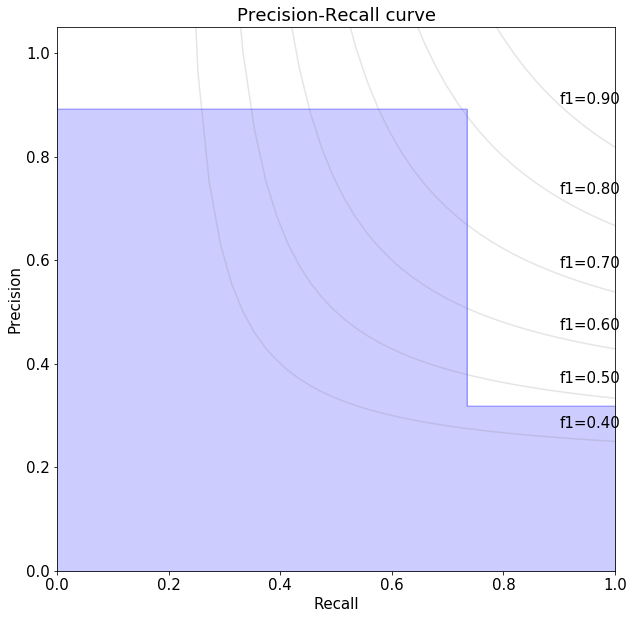

(None, None)

In [129]:
model(LogisticRegression(), norm_train_x, norm_valid_x,norm_train_y,norm_valid_y)
